In [1]:
using VariPEPS
using TensorKit
using OptimKit
#using JLD2 #needed?

In this notebook we show the very basic functionality of the workhorse funtions of the `VariPEPS.jl` code

Specify the Bond-dimension `d`, the environment-bond-dimension `χ`. 

In [2]:
χ = 8
d = 2

2

Here specify the unit cell. For this we define an array "Pattern_arr" that represents the unit cell structure.\
The structure is [x-coodinate, y-coordinate].\
If two positions within the Pattern_arr are filled with the same number, we assume the tensors at these positions to be identical.\
The choice below corresponds to a unit cell like:   
     --> x \
    |     A   B \
   v      B   A \
   y
   

Note the convention used here 

In [3]:
Pattern_arr = Array{Any}(undef,2,2)

Pattern_arr[1,1] = 1
Pattern_arr[2,1] = 2
Pattern_arr[1,2] = 2
Pattern_arr[2,2] = 1;

For our first example we are going to look at the Heisenberg-antiferromagnet on the square lattice.\
Here we specify the keywords corresponding to this choice of model and lattice on in a tuple.

Regarding the keywords:\
**lattice**: tells us which lattice we use.\
**model**: which Hamiltonian are we using.\
**Ham_parameters**: Give values for the parameters in the Hamiltonian. Here we choose an anti-ferromagnetic model (J=1) with no magnetic field term (h = 0) which points in no direction (dir = [0,0,0])\
**Projector_type**: During the CTMRG algorithm we need projectors. These can be choosen in different ways. Here we choose the :half option. An other more expensive choice would be :fullfishman.\
**Space_type**: This tells us what the basic vector space is that we want to work with. As we have a TRS model here we can choose a real wavefunction so we choose ℝ. Otherwise choose ℂ.\

In [4]:
keywords = (lattice = :square, model = :Heisenberg_square, Ham_parameters = (J = 1, h = 0 , dir = [0,0,0]), Projector_type = :half, Space_type = ℝ, svd_type = :full_trunc)

(lattice = :square, model = :Heisenberg_square, Ham_parameters = (J = 1, h = 0, dir = [0, 0, 0]), Projector_type = :half, Space_type = ℝ, svd_type = :full_trunc)

The functiion 
```
initialize_PEPS()
```
initializes the PEPS-tensors. It takes 3 basic inputs:
1. The first input is the Bond dimension, 
2. the second input is the dimension of the local Hilbert space, --> This is 2 in the current example, as we are dealing with a spin 1/2 system.
3. the third one specified how many tensors need to be generated. --> In this example 2 since we have two inequivalent tensors in the unit cell.
The additional keywords can be used to specify some addtional options.

What is created here is just an array of TensorMaps with the right number of legs with the desired dimensionality.

Note that we can also enforce local symmetries and only optimize on the parametes for the local tensors that have this symmetry. --> Add mini example later.

In [5]:
loc_in = initialize_PEPS(d, 2, 2; seed = 1234, lattice = :square, Number_type = Float64, Space_type = ℝ); 

The ctmrg function performs a CTM-RG algorithm and returns an array of results based on some keyords: With the keywords `calc_energy`, which is `true` by default we output the energy based on the model that we chose. With the keyword `observe`, which is `false` by default we can choose to evaluate some observables, while with keyword `return_envs` we output the converged environment tensors if we choose it to be `true`

If we put the option 
```
conv_info = true
```
The function shows some output that idicates the status of the algorithm. 

The function takes as input the objects we created above: A set of local PEPS tensors (loc_in) as well as some information on the unit cell (Pattern_arr).
It can also be used to evaluate some list of observables. For the Heisenberg model these are by default the spin matrices. However the user can also specify a list of alternative observables to calculate. *this works analogously to specifying your own model and is explained in a seperate notebook*. Note that if we want to get the expectation values of the spin matrices we need to choose Space_type = ℂ above as they are complex matrices.


In [6]:
ctmrg_res = ctmrg(loc_in, χ, Pattern_arr; keywords..., observ = true, conv_info = true)

CTM-RG iteration 1


┌ Warning: scalartype(data) = ComplexF64 ⊈ ℝ)
└ @ TensorKit /Users/weerde/.julia/packages/TensorKit/IoGCl/src/tensors/tensor.jl:33


CTM-RG iteration 2
CTM-RG iteration 3
largest SV-difference of the C tensors is 0.08214345683230176
CTM-RG iteration 4
largest SV-difference of the C tensors is 0.07591351009293586
CTM-RG iteration 5
largest SV-difference of the C tensors is 0.06717991319721525
CTM-RG iteration 6
largest SV-difference of the C tensors is 0.008683946653476701
largest SV-difference of the C tensors 2 steps appart is 0.07586385985069195
CTM-RG iteration 7
largest SV-difference of the C tensors is 0.005604869417903467
largest SV-difference of the C tensors 2 steps appart is 0.010565721191755154
CTM-RG iteration 8
largest SV-difference of the C tensors is 0.0020988741694272853
largest SV-difference of the C tensors 2 steps appart is 0.0077037435873307525
CTM-RG iteration 9
largest SV-difference of the C tensors is 0.0009086117569055419
largest SV-difference of the C tensors 2 steps appart is 0.002864678989878973
CTM-RG iteration 10
largest SV-difference of the C tensors is 0.0002872851646079644
largest SV-d

2-element Vector{Any}:
 0.05392016650474915
  Any[-0.09524824440863261 + 0.0im, 0.0 - 7.528660544462309e-17im, -0.07208748908316916 + 0.0im, -0.06682630666396142 + 0.0im, 0.0 - 8.505896990732494e-17im, -0.09386847067084174 + 0.0im]

Some comments on additional options (skip on first reading): 

1. With the option svd_type = :GKL one can enable the iterative calculation of the singular values in the CTMRG algorithm.
This can be substantially faster for larger bond dimensions.
Note that in some cases, the GKL algorithm, that can be used for the SVD in the calculation of the projectors finds invariant subspaces and fails. 
In these cases the code will fall back to conventional SVD algorithms.

2. In the "energy_and_gradient" function as well as in the "ctmrg" function we have a keyword "adjust_χ" which is by default set to false. In that case the 
function works normally. However if we do not set the keyword to false but give instead a tuple, during the CTMRG routine the algorithm automatically increases the bond dimension
up to a maximal value "χ_max". This happens whenever the truncation error "err_trunc" that we obtain in the creation of the projectors is larger than a choosen tolerance err_tol.
Thus we set the keyword to "adjust_χ = (err_tol, χ_max)" in case we want the bond dimension to be increased during the optimization.

3. You can also return the environment tensors, if you want to use them further. For this just pass the keyword `return_envs = true`. This will return an array of environments, one for every distinct tensor in your unit cell. The environments themselves are `named tuples` and the enviornments are named after their direction (l - left, d- down, r- right, u- up).

For a state, obtained after a few optimization steps of the Heisenberg model we look at the truncation errors as 
a function of the bond dimension - with the corresponding energy. The upper block is for the "fullfishman"-projectors
while the lower block is for the "half"-projectors. We conclude from the convergence of the energy-expectation values
that a maximal trunctation error of ~10^-3 is a reasonable starting point. It can always be chosen more stricly.

```E = -0.6603737287187401 @ χ = 80, maximum(trunc_sv_arr) = 5.975686042268443e-5 
E = -0.6603737358938596 @ χ = 60, maximum(trunc_sv_arr) = 0.00012481759922763688
E = -0.6603737799922393 @ χ = 40, maximum(trunc_sv_arr) = 0.00031194042937930866
E = -0.6603736187795066 @ χ = 30, maximum(trunc_sv_arr) = 0.0006405720791402293
E = -0.6603724597506875 @ χ = 26, maximum(trunc_sv_arr) = 0.0009362616891090525
E = -0.6603639207050201 @ χ = 20, maximum(trunc_sv_arr) = 0.0020002907780533145
E = -0.6603793732337668 @ χ = 16, maximum(trunc_sv_arr) = 0.003927764975811235


E = -0.6603737141782002 @ χ = 80, maximum(trunc_sv_arr) = 8.859010589321488e-5
E = -0.6603736039935315 @ χ = 60, maximum(trunc_sv_arr) = 0.00018689030517925998
E = -0.6603739415374238 @ χ = 40, maximum(trunc_sv_arr) = 0.0004921465970557896
E = -0.6603749442733124 @ χ = 30, maximum(trunc_sv_arr) = 0.0011953646129798726
E = -0.6603675868543281 @ χ = 26, maximum(trunc_sv_arr) = 0.00172234383475717
E = -0.6603589442727148 @ χ = 20, maximum(trunc_sv_arr) = 0.003446092986088426
E = -0.6603566068572576 @ χ = 16, maximum(trunc_sv_arr) = 0.005807880961672133


the function energy_and_gradient is needed for the variational optimization. It calculates the gradient at the fixed point of the CTM-RG iteration.\
It takes the same basic arguments as the function `ctmrg()`.\
It returns the the energy of the state as well as the gradient.

In [7]:
e, gr = energy_and_gradient(loc_in, χ, Pattern_arr; keywords...)

(0.05392016650474915, TrivialTensorMap{CartesianSpace, 2, 3, Matrix{Float64}}[TensorMap((ℝ^2 ⊗ ℝ^2) ← (ℝ^2 ⊗ ℝ^2 ⊗ ℝ^2)):
[:, :, 1, 1, 1] =
 -0.026745182778163522  0.03910334589054693
 -0.004844009152072987  0.03407857049120499

[:, :, 2, 1, 1] =
 -0.007606129075621643  5.30557738169378e-5
 -0.009901585931899928  0.003187286240000778

[:, :, 1, 2, 1] =
 0.007464403166384043   0.03388851062988569
 0.0052494414006702805  0.02490456353757818

[:, :, 2, 2, 1] =
 -0.005153846065305549   0.013650871146658087
  0.011288042034458271  -0.00689970761813677

[:, :, 1, 1, 2] =
 -0.0246874179960162      0.031945813613003395
  0.0021495642980899647  -0.029645506488602473

[:, :, 2, 1, 2] =
 -0.012501424321424964  0.009147182633461402
 -0.008509595282385159  0.027657727823271024

[:, :, 1, 2, 2] =
 -0.0234996296043523   0.0561092190468088
 -0.01005003737584919  0.01060786591266349

[:, :, 2, 2, 2] =
 -0.0053616560672722835  0.022449102918750245
 -0.006924498980116333   0.01287421275422747
, TensorMap

Some additional notes (skip on first reading):

1. With the option svd_type = :GKL one can enable the iterative calculation of the singular values during the CTMRG algorithm.
This can be substantially faster for larger bond dimensions.
Note that in some cases, the GKL algorithm, that can be used for the SVD in the calculation of the projectors finds invariant subspaces and fails. 
In these cases the code will fall back to conventional SVD algorithms.

In the "energy_and_gradient" function as well as in the "ctmrg" function we have a keyword "adjust_χ" which is by default set to false. In that case the 
function works normally. However if we do not set the keyword to false but give instead a tuple, during the CTMRG routine the algorithm automatically increases the bond dimension
up to a maximal value "χ_max". This happens whenever the truncation error "err_trunc" that we obtain in the creation of the projectors is larger than a choosen tolerance err_tol.
Thus we set the keyword to "adjust_χ = (err_tol, χ_max)" in case we want the bond dimension to be increased during the optimization.

Now there are two ways to call the "energy_and_gradient" function.\
you can use:\
1. e, gr = energy_and_gradient(loc_in, χ, Pattern_arr; keywords...)\
This version is the standart version. It takes a (local PEPS, environment bond dimension, a pattern array for the unit cell; a bunch of keywords)

2. e, gr = energy_and_gradient(loc_in, χ, Pattern_arr, keywords; adjust_χ = false)\
In this version the only thing to be specified by keyword is "adjust_χ" which is either false of (max_χ, tol)\
TWO IMPORTANT CAVEATS:\
a) in this case χ needs to be an array as [χ]. This is needed for dynamical increase of χ (it needs to be a mutable type e.g. array)\
b) We can still specify the options that were previously specified by keywords. We just pass a tuple (named tuple actually) that contains the keywords we want\
to specify.\
THE SECOND OPTION IS JUST A WRAPPER AROUND THE FIRST VERSION WHICH RETURNS THE ADJUSTED χ VALUE IF IT IS INCREASED. THIS IS NEEDED FOR DYNAMICAL χ INCREASE.\


Now we should the above functions to variationally find the best d=2 approximation to the ground state of the Heisenberg antiferromagnet.

For this we can use gradient based optimizers like L-BFGS. They are implemented in different packages, here we use OptimKit.jl. (an alternative would be Optim.jl)\
for the optimization we need the following two functions:

In [8]:
function _finalize!(x,f,g, numiter)
    
    
    flush(stdout) #this just makes it so the output does not appear all at once.
    flush(stderr)

    
    #here we could save e.g. intermediate output.
    
    return x, f, g
end

function _inner(x, ξ_1, ξ_2)
    return dot(real(ξ_1), real(ξ_2)) + dot(imag(ξ_1), imag(ξ_2))
end

_inner (generic function with 1 method)

we specify the parameters that are used in the optimization. 

In [9]:
optimparas1 = (gradtol = 1e-5, verbosity = 2, maxiter = 100, linesearch = HagerZhangLineSearch(; c₁ = 1e-4, c₂ = 0.9, maxiter = 40))
kwargs = (finalize! = _finalize!, inner = _inner)

(finalize! = _finalize!, inner = _inner)

Here we call the function that optimizes based on our gradient function.\
This function returns the approximation to the ground state `x` found in this procedure, the ground state energy `e` as well as information on the convergence.\
Below we plot some of the results.

In [10]:
x, e, gr, numfg, info = optimize(x -> energy_and_gradient(x, χ, Pattern_arr, keywords; adjust_χ = false), loc_in, LBFGS(15; optimparas1... ); kwargs... )

┌ Info: LBFGS: initializing with f = 0.053920166505, ‖∇f‖ = 1.8419e-01
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:35
┌ Info: LBFGS: iter    1: f = -0.106304007298, ‖∇f‖ = 2.9021e-01, α = 1.00e+00, m = 0, nfg = 1
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    2: f = -0.455631939744, ‖∇f‖ = 3.3219e-01, α = 1.00e+00, m = 1, nfg = 1
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    3: f = -0.482478846371, ‖∇f‖ = 1.4418e-01, α = 1.00e+00, m = 2, nfg = 1
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    4: f = -0.550754442276, ‖∇f‖ = 5.2274e-02, α = 1.00e+00, m = 3, nfg = 1
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LBFGS: iter    5: f = -0.567339406789, ‖∇f‖ = 3.5640e-02, α = 1.00e+00, m = 4, nfg = 1
└ @ OptimKit /Users/weerde/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: LB

(TrivialTensorMap{CartesianSpace, 2, 3, Matrix{Float64}}[TensorMap((ℝ^2 ⊗ ℝ^2) ← (ℝ^2 ⊗ ℝ^2 ⊗ ℝ^2)):
[:, :, 1, 1, 1] =
 0.6580132751247719  -2.297756530214006
 0.7516691899401731  -0.6220220288259369

[:, :, 2, 1, 1] =
 0.49252319679607787  -0.34905098207897317
 0.14151936203173762   0.19429712021526946

[:, :, 1, 2, 1] =
 0.24295855987982856  -1.195467841268981
 0.99894771399696     -1.4684844832904211

[:, :, 2, 2, 1] =
 0.40235130960108056  -0.7976066546090412
 1.0183153371428093   -0.7574774464066323

[:, :, 1, 1, 2] =
 -0.1502995329377918   -1.7397902341855374
 -0.10446014477721793  -0.1639679859997412

[:, :, 2, 1, 2] =
 0.4322648827479428   -1.1894272932634296
 0.47394456429845144  -0.374734496953534

[:, :, 1, 2, 2] =
 -0.30235707142523355  0.0345779708882036
 -1.1931845151951246   0.8364811969599705

[:, :, 2, 2, 2] =
 -0.07666716033332877  -0.5793046128672348
 -0.5336352937509119   -0.17631208849950733
, TensorMap((ℝ^2 ⊗ ℝ^2) ← (ℝ^2 ⊗ ℝ^2 ⊗ ℝ^2)):
[:, :, 1, 1, 1] =
 -0.728007

In [11]:
using Plots

In [12]:
pval = plot(1:1:101, info[:,1], color = :blue, legend = false, ylabel = "⟨E⟩", xlabel = "iterations");

pgrad = plot(1:1:101, log10.(info[:,2]), color = :red, ylabel = " ‖∇E‖", legend = false);


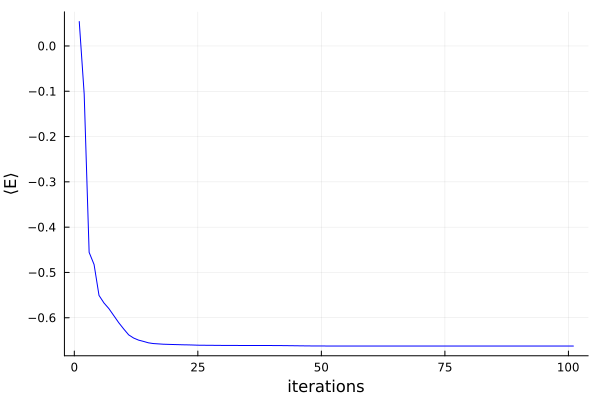

In [13]:
pval

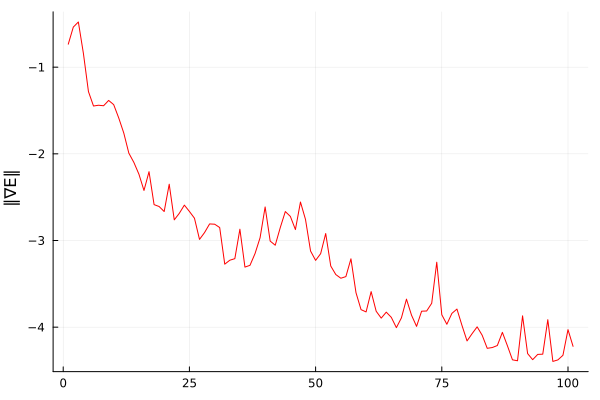

In [14]:
pgrad